# Influence of Feature Selection and PCA on a Small Dataset
This notebook covers the influence of feature selection and PCA on the Titanic Survivors dataset. Most of the preprocessing code such as data cleaning, encoding and transformation is adapted from the [Scikit-Learn ML from Start to Finish](https://www.kaggle.com/jeffd23/scikit-learn-ml-from-start-to-finish) work by [Jeff Delaney](https://www.kaggle.com/jeffd23).

## Import Data
Load the csv train and test files into a pandas dataframe and print the first 5 rows to see a sample of the data. Print also a statistics description of each feature.

In [1]:
import pandas as pd

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

train_df.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [2]:
train_df.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

## Visualise Data
To familiarise with the data and discover underlying patterns to exploit later in the machine learning models, we need to create some distribution, bar, and scatter plots. For a complete visualisation analysis check [Scikit-Learn ML from Start to Finish](https://www.kaggle.com/jeffd23/scikit-learn-ml-from-start-to-finish) work and my previous work [here](https://github.com/gtraskas/Udacity/tree/master/Data%20Analyst%20Nanodegree/P3_Intro_to_Data_Analysis).

## Engineer Features
1. Aside from 'Sex', the 'Age' feature is second in importance. To avoid overfitting, group people into logical human age groups.
2. Each 'Cabin' starts with a letter. Probably, this letter is more important than the number that follows, so slice it off.
3. 'Fare' is another continuous value that should be simplified, placing the values into quartile bins accordingly.
4. Extract information from the 'Name' feature. Rather than use the full name, extract the last name and prefix and then append them as their own features.
5. Lastly, drop useless features ('Ticket', 'Name', and 'Embarked').

In [3]:
# Code adapted from https://www.kaggle.com/jeffd23/scikit-learn-ml-from-start-to-finish
def simplify_ages(df):
    df.Age = df.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df

def simplify_cabins(df):
    df.Cabin = df.Cabin.fillna('N')
    df.Cabin = df.Cabin.apply(lambda x: x[0])
    return df

def simplify_fares(df):
    df.Fare = df.Fare.fillna(-0.5)
    bins = (-1, 0, 8, 15, 31, 1000)
    group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df.Fare, bins, labels=group_names)
    df.Fare = categories
    return df

def format_name(df):
    df['Lname'] = df.Name.apply(lambda x: x.split(' ')[0])
    df['NamePrefix'] = df.Name.apply(lambda x: x.split(' ')[1])
    return df    
    
def drop_features(df):
    return df.drop(['Ticket', 'Name', 'Embarked'], axis=1)

def transform_features(df):
    df = simplify_ages(df)
    df = simplify_cabins(df)
    df = simplify_fares(df)
    df = format_name(df)
    df = drop_features(df)
    return df

train_df = transform_features(train_df)
test_df = transform_features(test_df)
train_df.head()

PassengerId  Survived  Pclass     Sex          Age  SibSp  Parch  \
0            1         0       3    male      Student      1      0   
1            2         1       1  female        Adult      1      0   
2            3         1       3  female  Young Adult      0      0   
3            4         1       1  female  Young Adult      1      0   
4            5         0       3    male  Young Adult      0      0   

         Fare Cabin       Lname NamePrefix  
0  1_quartile     N     Braund,        Mr.  
1  4_quartile     C    Cumings,       Mrs.  
2  1_quartile     N  Heikkinen,      Miss.  
3  4_quartile     C   Futrelle,       Mrs.  
4  2_quartile     N      Allen,        Mr.

## Encode Data
Normalize and transform categorical non-numerical features to numerical with the `LabelEncoder` tool from `scikit-learn`, making out data more flexible for various algorithms.

In [4]:
from sklearn import preprocessing

def encode_features(df_train, df_test):
    features = ['Fare', 'Cabin', 'Age', 'Sex', 'Lname', 'NamePrefix']
    df_combined = pd.concat([df_train[features], df_test[features]])
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
        df_test[feature] = le.transform(df_test[feature])
    return df_train, df_test
    
train_df, test_df = encode_features(train_df, test_df)
train_df.head()

PassengerId  Survived  Pclass  Sex  Age  SibSp  Parch  Fare  Cabin  Lname  \
0            1         0       3    1    4      1      0     0      7    100   
1            2         1       1    0    0      1      0     3      2    182   
2            3         1       3    0    7      0      0     0      7    329   
3            4         1       1    0    7      1      0     3      2    267   
4            5         0       3    1    7      0      0     1      7     15   

   NamePrefix  
0          19  
1          20  
2          16  
3          20  
4          19

## Machine Learning
### Split Data to Train/Test Sets
Create train/test sets using the `train_test_split` function. The `test_size=0.2` indicates the percentage of the data that should be held over for testing.

In [5]:
from sklearn.model_selection import train_test_split

# Define the independent variables as features.
Xs = train_df.drop(['PassengerId', 'Survived'], axis=1)

# Define the target (dependent) variable as labels.
Ys = train_df['Survived']

# Create a train/test split using 30% test size.
X_train, X_test, y_train, y_test = train_test_split(Xs,
                                                    Ys,
                                                    test_size=0.2,
                                                    random_state=23)

# Check the split printing the shape of each set.
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(712, 9) (712,)
(179, 9) (179,)


### Evaluate Algorithms
Test and evaluate 5 algorithms:
1. Naive Bayes
2. Support Vector Machines
3. K Nearest Neighbors
4. Random Forest
5. AdaBoost

### Validate

Measure the effectiveness of the algorithm applying `KFold`. Split the data into 50 buckets, then run the algorithm using a different bucket as the test set for each iteration. Turn `shuffle=True` to shuffle the data points' order before splitting into folds.

In [6]:
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import KFold
from time import time

# Create the classifiers.
nb = GaussianNB()
svc = SVC()
dtc = DecisionTreeClassifier()
knc = KNeighborsClassifier()
rfc = RandomForestClassifier()
abc = AdaBoostClassifier()

# Create a dictionary of classifiers to choose from.
classifiers = {"GaussianNB": nb, "SVM": svc, "Decision Trees": dtc, 
               "KNN": knc, "Random Forest": rfc, "AdaBoost": abc}

# Create a function that runs and evaluates the classifiers.
def test_clfs(clf):
    
    # Create the KFold cross validation iterator.
    kf = KFold(n_splits=50, shuffle=True, random_state=23)
    
    outcomes = []
    fold = 0
    for train_index, test_index in kf.split(Xs):
        t0 = time()
        fold += 1
        X_train, X_test = Xs.values[train_index], Xs.values[test_index]
        y_train, y_test = Ys.values[train_index], Ys.values[test_index]
           
        # Fit the classifier to the data.
        clf.fit(X_train, y_train)
            
        # Create a set of predictions.
        predictions = clf.predict(X_test)
        # Evaluate predictions with accuracy score.
        accuracy = clf.score(X_test, y_test)
            
        outcomes.append(accuracy)
            
    mean_outcome = np.mean(outcomes)
        
    # Print the results.
    print("\nMean Accuracy: {0}".format(mean_outcome))
    print("\nTime passed: ", round(time() - t0, 3), "s\n")

for name, clf in classifiers.items():
    print("#"*55)
    print(name)
    test_clfs(clf)

#######################################################
GaussianNB

Mean Accuracy: 0.7601960784313725

Time passed:  0.002 s

#######################################################
SVM

Mean Accuracy: 0.6271895424836601

Time passed:  0.03 s

#######################################################
Decision Trees

Mean Accuracy: 0.7644444444444445

Time passed:  0.002 s

#######################################################
KNN

Mean Accuracy: 0.5996078431372549

Time passed:  0.002 s

#######################################################
Random Forest

Mean Accuracy: 0.8041176470588235

Time passed:  0.02 s

#######################################################
AdaBoost

Mean Accuracy: 0.8263398692810456

Time passed:  0.088 s



* Select **Adaboost** as the best algorithm, since it gives the best accuracy scores.

### Influence of Feature Selection & PCA

Investigate if Feature Selection and `PCA` can improve the performance of AdaBoost.

#### Feature Selection

Select the best features with `SelectKBest`, which removes all but the k highest scoring features.

#### PCA

Reduce the dimensionnality of the data using the Principal Component Analysis (`PCA`).

#### Dimensionality Reduction

Use `GridSearchCV` and `Pipeline` to optimize over different classes of estimators. Compare unsupervised `PCA` dimensionality reduction to univariate feature selection `SelectKBest` during the grid search.


Accuracy score:  0.821229050279

Report:

             precision    recall  f1-score   support

          0       0.85      0.87      0.86       115
          1       0.76      0.73      0.75        64

avg / total       0.82      0.82      0.82       179


Best Mean Accuracy score:  0.817415730337

Best parameters:

{'clf__n_estimators': 50, 'reduce_dim': SelectKBest(k=9, score_func=<function f_classif at 0x116dfee18>), 'reduce_dim__k': 9}
[[100  15]
 [ 17  47]]
Time passed:  101.808 s


Pipeline(memory=None,
     steps=[('reduce_dim', SelectKBest(k=9, score_func=<function f_classif at 0x116dfee18>)), ('clf', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None))])

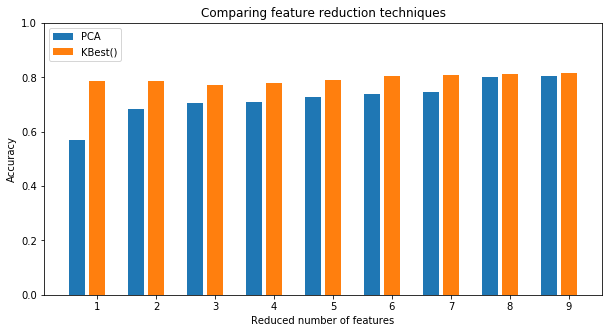

In [7]:
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Create the classifier.
clf = AdaBoostClassifier()

# Create the pipeline.
pipeline = Pipeline([('reduce_dim', PCA()),
                     ('clf', clf)])

# Create the parameters.
n_feature_options = [1, 2, 3, 4, 5, 6, 7, 8, 9]
n_estimators = [50]
parameters = [{'reduce_dim': [PCA(iterated_power=7)],
               'reduce_dim__n_components': n_feature_options,
               'clf__n_estimators': n_estimators},
              {'reduce_dim': [SelectKBest()],
               'reduce_dim__k': n_feature_options,
               'clf__n_estimators': n_estimators}]

reducer_labels = ['PCA', 'KBest()']

# Create a function to get the best estimator and print the reports.
def compare_estimators():
    t0 = time()

    # Create the KFold cross-validator.
    kf = KFold(n_splits=50, shuffle=True, random_state=23)

    # Create accuracy score to compare each combination.
    scoring = {'Accuracy': make_scorer(accuracy_score)}

    # Create the grid search.
    grid = GridSearchCV(estimator=pipeline,
                        param_grid=parameters,
                        scoring=scoring,
                        cv=kf, refit='Accuracy')

    # Fit grid search combinations.
    grid.fit(X_train, y_train)

    # Make predictions.
    predictions = grid.predict(X_test)

    # Evaluate using sklearn.classification_report().
    report = classification_report(y_test, predictions)

    # Get the best parameters and scores.
    best_parameters = grid.best_params_
    best_score = grid.best_score_
    
    mean_scores = np.array(grid.cv_results_['mean_test_Accuracy'])
    # scores are in the order of param_grid iteration, which is alphabetical
    mean_scores = mean_scores.reshape(len(n_estimators), -1, len(n_feature_options))
    # select score for best C
    mean_scores = mean_scores.max(axis=0)
    bar_offsets = (np.arange(len(n_feature_options)) *
                   (len(reducer_labels) + 1) + .5)

    plt.figure(figsize=(10, 5))
    for i, (label, reducer_scores) in enumerate(zip(reducer_labels, mean_scores)):
        plt.bar(bar_offsets + i, reducer_scores, label=label)

    plt.title("Comparing feature reduction techniques")
    plt.xlabel('Reduced number of features')
    plt.xticks(bar_offsets + len(reducer_labels) / 2, n_feature_options)
    plt.ylabel('Accuracy')
    plt.ylim((0, 1))
    plt.legend(loc='upper left')

    # Print the results.
    print("\nAccuracy score: ", accuracy_score(y_test, predictions))
    print("\nReport:\n")
    print(report)
    print("\nBest Mean Accuracy score: ", best_score)
    print("\nBest parameters:\n")
    print(best_parameters)
    print(confusion_matrix(y_test, predictions))
    print("Time passed: ", round(time() - t0, 3), "s")
    
    return grid.best_estimator_

compare_estimators()

* It seems that `SelectKBest` performs better than `PCA` for all the cases, but the accuracy score has not improved significantly after dimensionality reduction. Actually, it was found that the best model keeps all the features (k=9).

### Tune

To get an improved performance, optimise the hyperparameters that impact the model using `GridSearchCV`. The effectiveness of the algorithm is validated with `StratifiedShuffleSplit` and the evaluation with multiple metrics such as accuracy, precision, and recall.

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit

# Create the classifier.
clf = AdaBoostClassifier()

# Create the parameters.
parameters = {'n_estimators': [10, 25, 50, 75],
              'algorithm': ['SAMME', 'SAMME.R'],
              'random_state': [3]}

# Find the best estimator and print the reports.
t0 = time()

# Create the Stratified ShuffleSplit cross-validator.
sss = StratifiedShuffleSplit(n_splits=50, test_size=0.2, random_state=3)

# Create multiple evaluation metrics to compare each combination.
scoring = {'AUC': 'roc_auc',
           'Accuracy': make_scorer(accuracy_score),
           'Precision': 'precision',
           'Recall': 'recall',
           'f1': 'f1'}

# Create the grid search.
grid = GridSearchCV(estimator=clf,
                    param_grid=parameters,
                    scoring=scoring,
                    cv=sss, refit='Accuracy')

# Fit grid search combinations.
grid.fit(X_train, y_train)

# Make predictions.
predictions = grid.predict(X_test)

# Evaluate using sklearn.classification_report().
report = classification_report(y_test, predictions)

# Get the best parameters and scores.
best_parameters = grid.best_params_
best_score = grid.best_score_

# Print the results.
print("\nAccuracy score: ", accuracy_score(y_test, predictions))
print("\nReport:\n")
print(report)
print("\nBest Accuracy score: ", best_score)
print("\nBest parameters:\n")
print(best_parameters)
print(confusion_matrix(y_test, predictions))
print("Time passed: ", round(time() - t0, 3), "s")

best_clf = grid.best_estimator_


Accuracy score:  0.821229050279

Report:

             precision    recall  f1-score   support

          0       0.85      0.87      0.86       115
          1       0.76      0.73      0.75        64

avg / total       0.82      0.82      0.82       179


Best Accuracy score:  0.819300699301

Best parameters:

{'algorithm': 'SAMME.R', 'n_estimators': 25, 'random_state': 3}
[[100  15]
 [ 17  47]]
Time passed:  42.804 s


### Predict the Actual Test Data
Finally, make the predictions and export them to a csv file.

In [9]:
passenger_ids = test_df['PassengerId']
predictions = best_clf.predict(test_df.drop('PassengerId', axis=1))

output = pd.DataFrame({ 'PassengerId' : passenger_ids, 'Survived': predictions })
output.to_csv('titanic_predictions.csv', index = False)
output.head()

PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1